# Finding Strongly-Connected Components (SCCs) in Interaction Contribution
This notebook computes SCCs from the interaction contributions $E^I$ in the article. It requires a successful computation of LRP for all genes using:
```
python lrp.py -m <path-to-EMOGI-model> --all
```
The notebook features several analyses of the SCCs like their correlation with betweenness, which features are mainly altered and also writes the SCCs to file as gml which can be read by Cytoscape.
It also estimates a threshold for the edges that maximizes the number of SCCs and does pathway & GO enrichment analysis.

## Imports

In [1]:
# data science & classics
import pandas as pd
import numpy as np
import h5py
import networkx as nx
import os, sys
import subprocess
import scipy

# clustering & embedding
from sklearn.cluster import SpectralBiclustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster import hierarchy
import umap
import sklearn
from sklearn import preprocessing

# other modules of mine
sys.path.append(os.path.abspath('../EMOGI'))
import gcnIO, postprocessing, utils
sys.path.append(os.path.abspath('../pancancer/preprocessing'))
import preprocessing_utils as pre_utils

# GO enrichment analysis
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.test_data.genes_NCBI_9606_ProteinCoding import GENEID2NT as GeneID2nt_human
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

sys.path.append(os.path.abspath('../pancancer'))
import preprocessing_utils as ut

# plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.rc('font', family='Arial')
%matplotlib inline

## Parameters:

* `compute_optimal_cutoff`: Whether to compute the cutoff for the number of SCCs

In [2]:
compute_optimal_cutoff = False

## Relevant Paths
* `achilles_data_path`: Path to the achilles CRSIPR gene effect csv file that can be downloaded [here](https://depmap.org/portal/download/)
* `model_dir`: Path to the training directory where both, the model and the LRP contributions are stored.

In [3]:
achilles_data_path = '../data/pancancer/Achilles/Achilles_gene_effect.csv'
model_dir = '../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/'
ncg_cancer_genes_path = '../data/pancancer/NCG/cancergenes_list.txt'
oncokb_path = '../data/pancancer/oncoKB/cancerGeneList.txt'
cgc_path = '../data/pancancer/cosmic/cancer_gene_census.csv'
ongene_path = '../data/pancancer/ongene_tsgene/Human_Oncogenes.txt'
tsgene_path = '../data/pancancer/ongene_tsgene/Human_TSGs.txt'
driverdb_path = '../data/pancancer/driverdb/{}_download_tab.txt' # needs formatting for evidence type
baileyetal_path = '../data/pancancer/comprehensive_characterization_of_cancer_driver_genes_and_mutations/comprehensive_characterization_cancer_genes.csv'

## Functions

In [4]:
def get_pathway_enrichment(genes, universe, cluster_idx, out_dir, clean_up=True):
    # write cluster information to disk
    genes.set_index('ID').to_csv(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)), sep='\t')
    universe.set_index('ID').to_csv(os.path.join(out_dir, 'universe_cluster_{}.tsv'.format(cluster_idx)), sep='\t')

    # formulate command to hand to R script
    cmd = 'Rscript KEGG.R {} {} {} {}'.format(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)),
                                              os.path.join(out_dir, 'universe_cluster_{}.tsv'.format(cluster_idx)),
                                              os.path.join(out_dir, 'cluster_{}_pathways.txt'.format(cluster_idx)),
                                              genes.shape[0]
                                          )
    res = subprocess.call(cmd, shell=True)
    # read pathways and return
    top_pathways = pd.read_csv(os.path.join(model_dir, 'cluster_{}_pathways.txt'.format(cluster_idx)),
                               sep='\t')[['Pvalue', 'Count', 'Size', 'Term']].head(5)
    
    if clean_up:
        os.remove(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)))
        os.remove(os.path.join(out_dir, 'universe_cluster_{}.tsv'.format(cluster_idx)))

    return top_pathways


def plot_representative(ax, rep, rep_std, xlabels, title=None):
    ax.bar(x=np.arange(len(xlabels)), height=rep.values, tick_label=xlabels)#, yerr=rep_std.values)
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', labelsize=16)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    if not title is None:
        ax.set_title(title, fontsize=18)
    ax.set_ylabel('Feature\nContribution', fontsize=18)
    utils.colorize_by_omics(ax, xlabels)


def plot_representative_heatmap(ax, rep, xlabels, title=None):
    vmax = rep.max()
    vmin = rep.min()
    print ("Max and min ", vmax, vmin)
    rep = rep.reshape(16, 3, order='F')
    inner = gridspec.GridSpecFromSubplotSpec(3, 1, hspace=0, subplot_spec=ax)
    omics = ['Mutation', 'Methylation', 'Expression']
    cmaps = [sns.color_palette("Reds"), sns.color_palette("Blues"), sns.color_palette("Greens")]

    for c in range(3):
        ax = plt.Subplot(fig, inner[c])
        xticklabels = False
        if c == 2:
            xticklabels = [i.split(':')[1] for i in xlabels[:16]]
        sns.heatmap(rep[:, c].reshape(1, -1), ax=ax, xticklabels=xticklabels,
                    cbar=False, cmap=cmaps[c],
                    cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
                    vmax=vmax, vmin=vmin)
        ax.set_yticklabels([omics[c]], rotation=0, fontsize=10)
        if not title is None and c == 0:
            ax.set_title(title, fontsize=16)
        fig.add_subplot(ax)
    plt.subplots_adjust(bottom=0.05, hspace=0.05, wspace=0)


def plot_pathway_information(ax, pathways):
    for i in range(pathways.shape[0]):
        ax.text(0, 0.9-i*0.2, '{0:.0E}  {1}  {2}  {3}'.format(pathways.iloc[i]['Pvalue'],
                                                              pathways.iloc[i]['Count'],
                                                              pathways.iloc[i]['Size'],
                                                              pathways.iloc[i]['Term']
                                                             ), fontsize=12
               )
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

### Load PPI Edge Contributions

In [5]:
lrp_neighbor_matrix = np.load(os.path.join(model_dir, 'lrp_sigmoid', 'support_0_mean_sum.npy'))
count = 1
for i in range(5):
    p = os.path.join(model_dir, 'lrp_sigmoid', 'support_{}_mean_sum.npy'.format(i))
    if os.path.isfile(p):
        lrp_neighbor_matrix += np.load(p)
        count += 1
        print ("Loaded and added neighbor contributions with support {}".format(i))
lrp_neighbor_matrix = lrp_neighbor_matrix / float(count)
lrp_neighbor_matrix.min(), lrp_neighbor_matrix.max()

Loaded and added neighbor contributions with support 0
Loaded and added neighbor contributions with support 1


(-78.10830990555824, 72.98056168227582)

In [6]:
(lrp_neighbor_matrix < 0).sum()

246189

### Load Feature LRP Results & EMOGI Predictions

In [7]:
# get the relevant data from the input container
args, _ = gcnIO.load_hyper_params(model_dir)
with h5py.File(os.path.join(model_dir, args['data']), 'r') as f:
    node_names = f['gene_names'][:]
    feature_names = f['feature_names'][:]
    adjacency = f['network'][:]
    features = f['features'][:]

# Load the LRP feature results for all genes
feature_contributions = np.load(os.path.join(model_dir, 'lrp_sigmoid', 'feat_mean_all.npy'))
# replace 0 values with small random ones to prevent numerical issues
feat_contrib_df = pd.DataFrame(feature_contributions, index=node_names[:feature_contributions.shape[0], 1], columns=feature_names)
zero_rows = feat_contrib_df[(feat_contrib_df == 0).all(axis=1)]
feat_contrib_df.loc[(feat_contrib_df == 0).all(axis=1)] = np.random.randn(*zero_rows.shape)*0.00001
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])

# get the predictions of the model
pred = postprocessing.load_predictions(model_dir)

In [8]:
lrp_neighbor_matrix_abs = lrp_neighbor_matrix.copy()
#lrp_neighbor_matrix_abs = np.abs(lrp_neighbor_matrix_abs)
lrp_neighbor_matrix_abs[lrp_neighbor_matrix_abs < 0] = 0

C_abs = nx.from_pandas_adjacency(pd.DataFrame(lrp_neighbor_matrix_abs, index=node_names[:, 1],
                                              columns=node_names[:, 1]),
                                 create_using=nx.MultiDiGraph)

C_abs.remove_edges_from(list(nx.selfloop_edges(C_abs)))
sorted(C_abs.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]

[('RITA1', 'NEK2', {'weight': 5.848961219825749}),
 ('ATMIN', 'WRNIP1', {'weight': 5.719151518863786}),
 ('EXOSC2', 'ST6GALNAC1', {'weight': 4.395462125936763}),
 ('ARID3B', 'HELZ', {'weight': 3.3453603560771814}),
 ('CRAT', 'PEX5', {'weight': 3.2524595724024263}),
 ('ZNF181', 'DDX46', {'weight': 3.145780644502213}),
 ('MXD1', 'VDR', {'weight': 3.030064549193373}),
 ('PLA2R1', 'PLA2G10', {'weight': 2.920743430950946}),
 ('HIST2H4B', 'HIST2H3A', {'weight': 2.8685326444259185}),
 ('HIST2H4B', 'HIST2H3C', {'weight': 2.828029795970691})]

### Compute Optimal Threshold
This only executes if the flag is set earlier because it is time-consuming

In [9]:
def get_number_of_modules(threshold):
    to_remove = []
    for u, v, weight in C_abs.edges(data='weight'):
        if weight < threshold:
            to_remove.append((u, v))
    C_abs_copy = C_abs.copy()
    C_abs_copy.remove_edges_from(to_remove)
    module_sizes = [len(c) for c in sorted(nx.strongly_connected_components(C_abs_copy), key=len, reverse=True) if len(c) > 5]
    return len(module_sizes)

if compute_optimal_cutoff:
    thresholds = np.arange(0.01, 0.35, 0.02)
    number_of_modules = []
    for thr in thresholds:
        number_of_modules.append(get_number_of_modules(thr))
    number_of_modules
    
    fig = plt.figure(figsize=(14, 8))
    plt.bar(x=list(range(len(number_of_modules))), height=number_of_modules)
    _ = plt.xticks(ticks=list(range(len(number_of_modules))), labels=['{0:.2f}'.format(i) for i in thresholds], fontsize=15)
    plt.xlabel('Thresholds for Edge Weight', fontsize=20)
    plt.ylabel('Number of Modules of Size > 5', fontsize=20)
    print (number_of_modules)
    plt.gca().tick_params(axis='y', which='major', labelsize=20)
    #fig.savefig(os.path.join(model_dir, 'SCCs', 'module_sizes_posonly.svg'))

### Compute the SCCs

In [10]:
min_edge_weight = 0.19

nw_thr = np.where(lrp_neighbor_matrix_abs <= min_edge_weight, 0, lrp_neighbor_matrix)
nw_thr_df = pd.DataFrame(data=nw_thr, index=node_names[:, 1], columns=node_names[:, 1])
G = nx.from_pandas_adjacency(nw_thr_df, create_using=nx.MultiDiGraph)

In [11]:
"""
nx.set_node_attributes(G=G, values=pred.set_index('Name')['Prob_pos'].to_dict(), name='OutputProb')
#nx.set_node_attributes(G=G, values=pred.set_index('Name')['label'].to_dict(), name='KnownCancerGene')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['Pred_Cancer_Gene'].to_dict(), name='PredictedCancerGene')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['essentiality'].to_dict(), name='Essentiality')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['DatabaseKnowledge'].to_dict(), name='DatabaseKnowledge')

nx.set_node_attributes(G=G, values=pred.set_index('Name')['CGC'].to_dict(), name='CGC')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['Bailey'].to_dict(), name='BaileyEtAl')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['NCGCandidates'].to_dict(), name='NCGCandidates')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['OncoKB'].to_dict(), name='OncoKB')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['DriverDB'].to_dict(), name='DriverDB')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['ONGene_TSGene'].to_dict(), name='ONGeneTSGene')
"""
print ([len(c) for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True) if len(c) > 1])
print (len(max(nx.strongly_connected_components(G), key=len)))
nodes_component = list(max(nx.strongly_connected_components(G), key=len))
x = pd.DataFrame(nodes_component, columns=['Name'])
all_components = [list(c) for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True) if len(c) > 1]

[47, 16, 11, 11, 9, 9, 7, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
47


### Are the SCCs Enriched with Essential Genes?

(102.578125, 1.0, 87.51751981628269, 2.0)

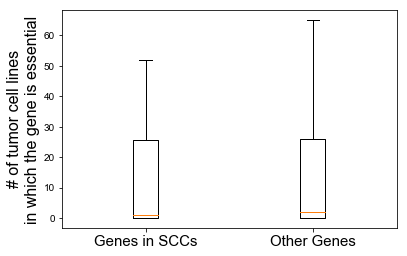

In [12]:
pred['Pred_Cancer_Gene'] = False
pred.loc[pred.Prob_pos >= 0.89, 'Pred_Cancer_Gene'] = True

# get essentiality from Achilles data
essential_genes = pd.read_csv(achilles_data_path).T
essential_genes.columns = essential_genes.loc['Unnamed: 0']
essential_genes.drop('Unnamed: 0', inplace=True)
essential_genes['Name'] = [i.split('(')[0].strip() for i in essential_genes.index]
essential_genes.set_index('Name', inplace=True)
essentiality = (essential_genes < -0.5).sum(axis=1)

# join essentiality with the predictions
pred = pred.join(essentiality.rename('essentiality'), on='Name', how='left')
pred.essentiality.fillna(0, inplace=True)
pred.essentiality = pred.essentiality.astype('int32')

# get all genes somewhere in the 10 largest SCCs
all_genes_in_sccs = []
for i in range(10):
    all_genes_in_sccs += all_components[i]

l1 = pred[pred.Name.isin(all_genes_in_sccs)].essentiality
l2 = pred[~pred.Name.isin(all_genes_in_sccs)].essentiality
_ = plt.boxplot([l1, l2], showfliers=False, labels=['Genes in SCCs', 'Other Genes'])
_ = plt.xticks([1,2], ['Genes in SCCs', 'Other Genes'], fontsize=15)
plt.ylabel('# of tumor cell lines\nin which the gene is essential', fontsize=16)
l1.mean(), l1.median(), l2.mean(), l2.median()

Text(0, 0.5, 'Average Essentiality')

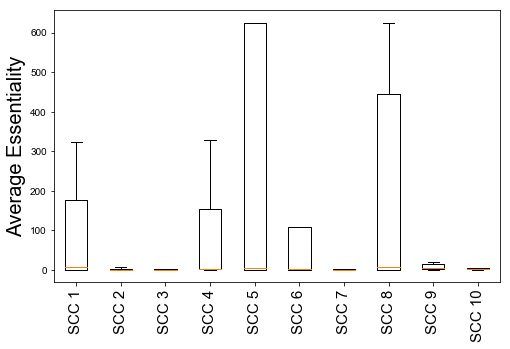

In [13]:
essentiality_for_sccs = []
essentiality_err = []
for i in range(10):
    mean_ess = pred[pred.Name.isin(all_components[i])].essentiality
    essentiality_for_sccs.append(mean_ess)
    essentiality_err.append(mean_ess.std())

fig = plt.figure(figsize=(8, 5))
_ = plt.boxplot(essentiality_for_sccs, showfliers=False)
_ = plt.xticks(ticks=np.arange(1, 11), labels=['SCC {}'.format(j+1) for j in range(10)], fontsize=15, rotation=90)
plt.ylabel('Average Essentiality', fontsize=20)

### Add Database Knowledge to SCCs

In [14]:
# get the NCG cancer genes
known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open(ncg_cancer_genes_path, 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

oncokb_genes = pd.read_csv(oncokb_path, sep='\t')
# remove low confidence genes
oncokb_no_ncg_highconf = oncokb_genes[oncokb_genes['# of occurrence within resources (Column D-J)'] >= 3]

# comprehensive characterization paper genes
cancer_genes_paper = pd.read_csv(baileyetal_path, sep='\t', header=3)
cancer_genes_paper = pd.Series(cancer_genes_paper.Gene.unique())

# driverDB
driverdb_genes = []
thresholds_study = {'mutation': 25, 'CNV': 5, 'methylation': 2}
for evidence in ['mutation', 'CNV', 'methylation']:
    driverdb_data = pd.read_csv(driverdb_path.format(evidence), sep='\t')
    all_driver_genes = []
    for index, row in driverdb_data.iterrows():
        all_driver_genes += [i.strip() for i in row.driver_gene.split(',') if not i.strip() == '']
    study_counts = pd.Series(all_driver_genes).value_counts()
    driverdb_genes += list(study_counts[study_counts > thresholds_study[evidence]].index)
driverdb_genes = pd.Series(list(set(driverdb_genes)))

# OnGene + TSGene
oncogenes = pd.read_csv(ongene_path, sep='\t')
tsgs = pd.read_csv(tsgene_path, sep='\t')
cancer_genes = list(set(list(oncogenes.OncogeneName) + list(tsgs.GeneSymbol)))

# COSMIC CGC
cgc = pd.read_csv(cgc_path)
cgc = list(set(cgc['Gene Symbol']))

pred['DatabaseKnowledge'] = "None"
pred.loc[pred.Name.isin(candidate_cancer_genes), 'DatabaseKnowledge'] = "NCGCandidates"
pred.loc[pred.Name.isin(oncokb_genes['Hugo Symbol']), 'DatabaseKnowledge'] = "OncoKB"
pred.loc[pred.Name.isin(driverdb_genes), 'DatabaseKnowledge'] = "DriverDB"
pred.loc[pred.Name.isin(cancer_genes), 'DatabaseKnowledge'] = "ONGeneTSGene"
pred.loc[pred.Name.isin(cancer_genes_paper), 'DatabaseKnowledge'] = "Bailey"
pred.loc[pred.Name.isin(cgc), 'DatabaseKnowledge'] = "CGC"
"""
pred['CGC'] = False
pred.loc[pred.Name.isin(cgc), 'CGC'] = True
pred['Bailey'] = False
pred.loc[pred.Name.isin(cancer_genes_paper), 'Bailey'] = True
pred['NCGCandidates'] = False
pred.loc[pred.Name.isin(candidate_cancer_genes), 'NCGCandidates'] = True
pred['OncoKB'] = False
pred.loc[pred.Name.isin(oncokb_genes['Hugo Symbol']), 'OncoKB'] = True
pred['DriverDB'] = False
pred.loc[pred.Name.isin(driverdb_genes), 'DriverDB'] = True
pred['ONGene_TSGene'] = False
pred.loc[pred.Name.isin(cancer_genes), 'ONGene_TSGene'] = True
"""
pred.head()

,Name,label,Num_Pos,Prob_pos,Std_Pred,Pred_Cancer_Gene,essentiality,DatabaseKnowledge
ID,,,,,,,,
ENSG00000284792,PTEN,True,10,1.000,0.000,True,2,CGC
ENSG00000136997,MYC,True,10,1.000,0.000,True,622,CGC
ENSG00000141646,SMAD4,True,10,1.000,0.000,True,1,CGC
ENSG00000141510,TP53,True,10,1.000,0.000,True,32,CGC
ENSG00000146648,EGFR,True,10,1.000,0.000,True,69,CGC


In [15]:
pred.DatabaseKnowledge.value_counts()

None             10545
ONGeneTSGene      1092
NCGCandidates      919
CGC                630
OncoKB             238
Bailey             102
DriverDB           101
Name: DatabaseKnowledge, dtype: int64

In [16]:
all_components_larger2 = [i for i in all_components if len(i) > 2]
flat_list = [gene for scc in all_components_larger2 for gene in scc]
print ("All SCCs (> 2) contain {} genes in total".format(len(set(flat_list))))
print ("The first 10 SCCs (>5) contain {} genes in total".format(len(set(all_genes_in_sccs))))

All SCCs (> 2) contain 250 genes in total
The first 10 SCCs (>5) contain 128 genes in total


### Which Omics Levels are Important in SCCs

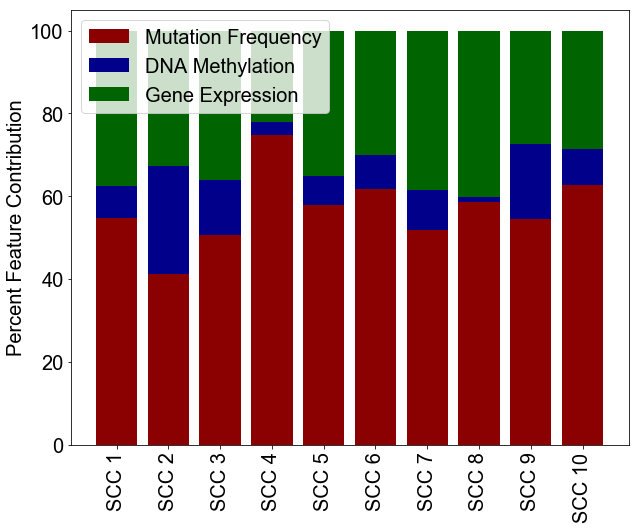

In [17]:
# group the feature contributions by omics level
contrib_df_copy = feat_contrib_df.copy()
contrib_df_copy[contrib_df_copy < 0] = 0
contrib_df_copy.loc['Omics_Type', :] = [i[0] for i in feat_contrib_df.columns.str.split(':')]
omics_contributions = contrib_df_copy.T.groupby('Omics_Type').sum(axis=1).T

# turn that into probabilities
def minmax(x):
    return x / x.sum(axis=0)
omics_contributions_probs = omics_contributions.apply(minmax, axis=1)

#compute a stacked barplot from that
stacked_barplot_vals = {}
groups = list(range(10))
for omics in ['MF', 'METH', 'GE']:
    omics_vals = []
    for scc in all_components[:10]:
        omics_vals.append(omics_contributions_probs.loc[omics_contributions_probs.index.isin(scc), omics].mean())
    stacked_barplot_vals[omics] = omics_vals

df = pd.DataFrame(stacked_barplot_vals)
totals = [i+j+k for i,j,k in zip(df['MF'], df['METH'], df['GE'])]
mutation_bars = [i / j * 100 for i,j in zip(df['MF'], totals)]
methylation_bars = [i / j * 100 for i,j in zip(df['METH'], totals)]
expression_bars = [i / j * 100 for i,j in zip(df['GE'], totals)]

fig = plt.figure(figsize=(10, 8))
plt.bar(groups, mutation_bars, color='darkred', label='Mutation Frequency')
plt.bar(groups, methylation_bars, bottom=mutation_bars, color='darkblue', label='DNA Methylation')
plt.bar(groups, expression_bars, bottom=[i+j for i,j in zip(mutation_bars, methylation_bars)],
        color='darkgreen', label='Gene Expression')

plt.legend(loc='upper left', ncol=1, fontsize=20)
plt.ylabel('Percent Feature Contribution', fontsize=20)
_ = plt.xticks(groups, ['SCC {}'.format(i+1) for i in range(10)], fontsize=15, rotation=90)
plt.gca().tick_params(axis='both', which='major', labelsize=20)
#fig.savefig(os.path.join(model_dir, 'SCCs', 'omics_contributions_sccs.svg'))

### Write SCCs to Disk

In [18]:
node_names_df = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
for i in range(10):
    fname = os.path.join(model_dir, 'SCCs', 'thr_019_noneg',
                         'lrp_neighbors_new_comp_{}_thr_{}.gml'.format(i+1, min_edge_weight))
    comp = all_components[i]
    nx.write_gml(G.subgraph(comp), path=fname)
    fname_nodes = os.path.join(model_dir, 'lrp_neighbors_new_comp_{}_thr_{}_nodes.csv'.format(i+1, min_edge_weight))
    nodes[nodes.Name.isin(comp)].to_csv(fname_nodes, sep='\t')
    print ("Graph written to: {}".format(fname))

Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_1_thr_0.19.gml
Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_2_thr_0.19.gml
Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_3_thr_0.19.gml
Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_4_thr_0.19.gml
Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_5_thr_0.19.gml
Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_6_thr_0.19.gml
Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_7_thr_0.19.gml
Graph written to: ../data/GCN/training/final_TCG

### Which Features are Most Altered in Each SCC
This can also be used to compute the feature contribution averages per SCC and determine if any of the SCCs is specific for a tissue or cancer type.

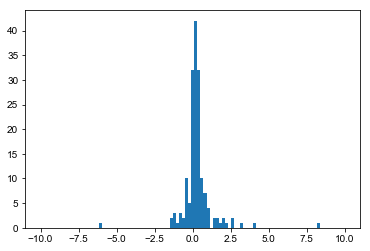

In [19]:
lrp_I = pd.DataFrame(lrp_neighbor_matrix, index=node_names[:, 1], columns=node_names[:, 1])
feat_importance_sccs = []
for i in range(len(all_components)):
    v = feat_contrib_df[feat_contrib_df.index.isin(all_components[i])].sum(axis=1).mean()
    feat_importance_sccs.append(v)
_ = plt.hist(feat_importance_sccs, bins=np.linspace(-10, 10, 100))

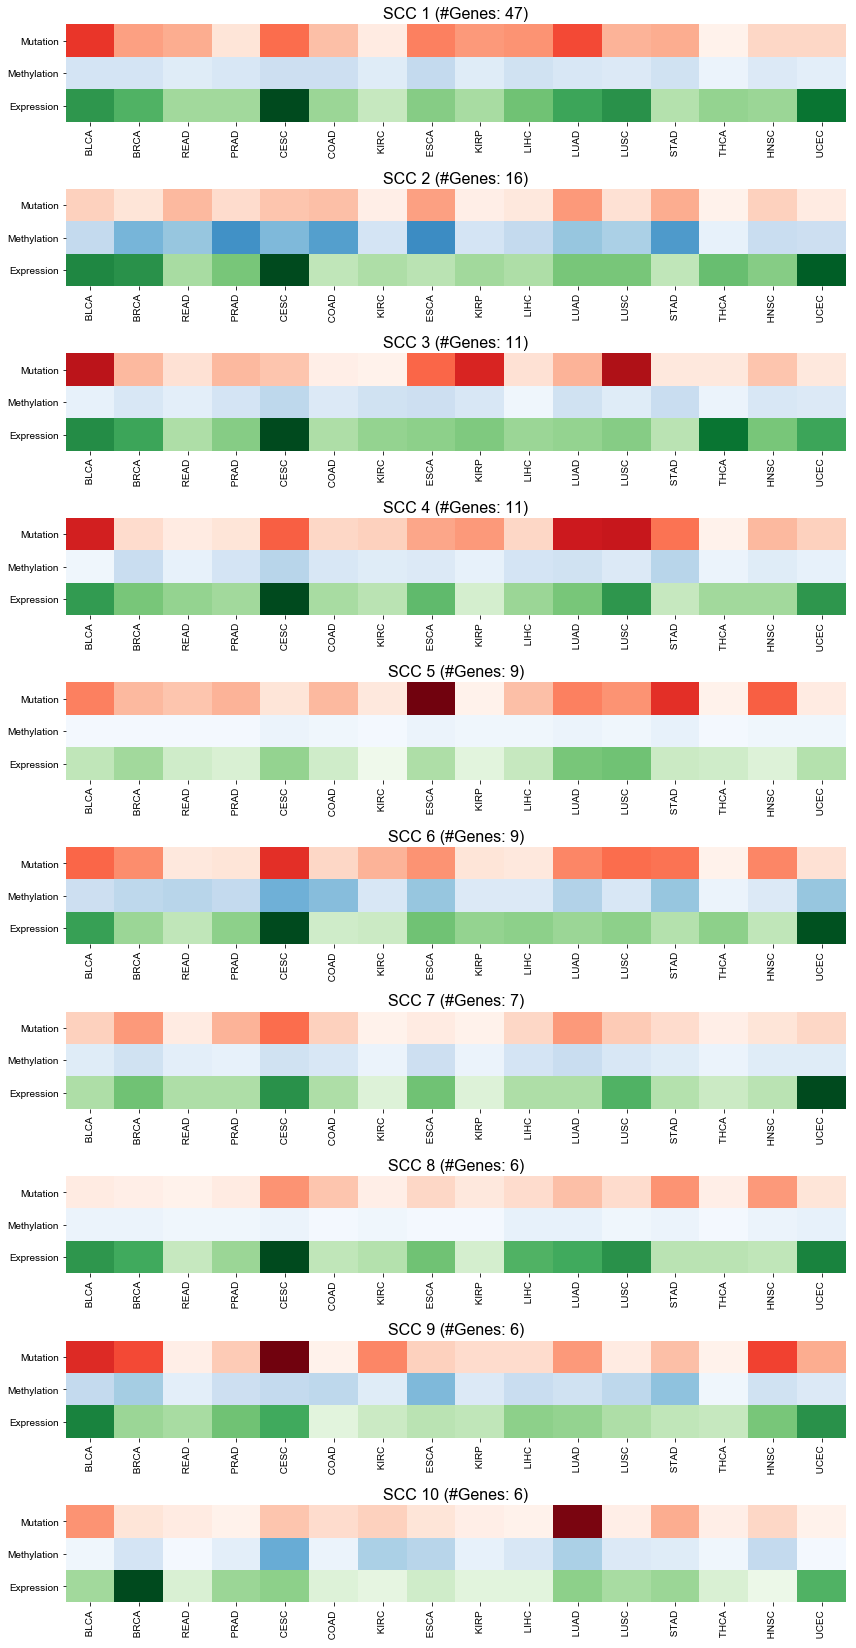

In [20]:
features_df = pd.DataFrame(features, index=node_names[:, 1], columns=feature_names)

n_to_plot = 10
feat_contrib_capped = feat_contrib_df.copy()
feat_contrib_capped[feat_contrib_capped < 0] = 0
fig = plt.figure(figsize=(12, n_to_plot*2+3), frameon=False)
outer_grid = gridspec.GridSpec(nrows=n_to_plot, ncols=1, figure=fig)

for scc_no in range(n_to_plot):
    # compute the representative for that SCC
    #representative = feat_contrib_capped[feat_contrib_capped.index.isin(all_components[scc_no])]
    representative = features_df[features_df.index.isin(all_components[scc_no])]
    # plot barplot for representative
    utils.lrp_heatmap_plot(fig, outer_grid[scc_no], representative.mean(axis=0).values,
                        title='SCC {0} (#Genes: {1})'.format(scc_no+1, representative.shape[0]),
                        xlabels=representative.columns
            )
fig.tight_layout()
#fig.savefig(os.path.join(model_dir, 'SCCs', 'thr_019_noneg', 'representatives_sccs_input_heatmap.pdf'))

### Are Some SCCs Enriched With Cancer Genes

Text(0, 0.5, '# of Known Cancer Genes')

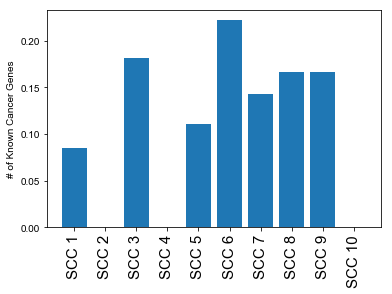

In [21]:
sum_known_comp = []
for i in range(10):
    comp_stats = pred[pred.Name.isin(all_components[i])].label
    sum_known_comp.append(comp_stats.mean())

plt.bar(x=np.arange(10), height=sum_known_comp)
_ = plt.xticks(ticks=np.arange(10), labels=['SCC {}'.format(j+1) for j in range(10)], fontsize=15, rotation=90)
plt.ylabel('# of Known Cancer Genes')

## Run Pathway/Enrichment Analyses for SCCs

### KEGG Pathway Analysis

In [23]:
pathway_sccs = []
for i in range(10):
    pathway_sccs.append(get_pathway_enrichment(nodes[nodes.Name.isin(all_components[i])], nodes, i, model_dir))

### GO Enrichment Analysis

In [24]:
# Get the data
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag("go-basic.obo")

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))

goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_human.keys(), # List of human protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2020-07-16) 47,259 GO Terms
HMS:0:00:04.570226 338,121 annotations READ: gene2go 
1 taxids stored: 9606
MF 18,162 annotated human genes
CC 19,414 annotated human genes
BP 18,597 annotated human genes

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 81% 16,864 of 20,913 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 85% 17,853 of 20,913 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 83% 17,359 of 20,913 population items found in association


In [25]:
for comp in range(10):
    geneids_study = [int(i) for i in list(ut.get_entrez_from_symbol(all_components[comp]).index) if not i is None]
    goea_results_all = goeaobj.run_study(geneids_study)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    out_dir = os.path.join(model_dir, 'SCCs', 'thr_019_noneg')
    #plot_results(os.path.join(out_dir, 'SCC_{}_goenrichment.png'.format(comp+1)), goea_results_sig)
    goeaobj.wr_xlsx(os.path.join(out_dir, 'SCC_{}_goenrichment.xlsx'.format(comp+1)), goea_results_sig)

querying 1-47...done.
Finished.
1 input query terms found no hit:
	['SEPT3']

Run BP Gene Ontology Analysis: current study set of 46 IDs ...
 98%     45 of     46 study items found in association
100%     46 of     46 study items found in population(20913)
Calculating 12,274 uncorrected p-values using fisher_scipy_stats
  12,274 GO terms are associated with 16,864 of 20,913 population items
     556 GO terms are associated with     45 of     46 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 46 IDs ...
 98%     45 of     46 study items found in association
100%     46 of     46 study items found in population(20913)
Calculating 1,754 uncorrected p-values using fisher_scipy_stats
   1,754 GO terms are associated with 17,85

## LRP Neighbor Contributions Introduce no New Interactions

In [ ]:
import lrp

In [ ]:
interpreter = lrp.LRP(model_dir=model_dir)

In [ ]:
lrp_scores = interpreter.compute_lrp('APC')
mean_feat, std_feat, mean_neighbors, std_neighbors = lrp_scores

In [ ]:
nn_contrib_s0 = pd.DataFrame(mean_neighbors[1], index=node_names[:, 1], columns=node_names[:, 1])
G = nx.from_pandas_adjacency(nn_contrib_s0)
A = nx.from_pandas_adjacency(pd.DataFrame(adjacency, index=node_names[:, 1], columns=node_names[:, 1]))
G.remove_edges_from(G.selfloop_edges())
G.number_of_edges()

In [ ]:
gene_name = 'APC'
contributers_tp53 = list(G.neighbors(gene_name))
same = 0
for neighbor in A.neighbors(gene_name):
    if not neighbor in contributers_tp53:
        print (neighbor)
    else:
        same += 1
same

In [ ]:
A.number_of_edges(), G.number_of_edges()

In [ ]:
len(list(contrib_all.neighbors('APC')))

In [ ]:

def edge_exists(source, target):
    if A.has_edge(source, target):

In [ ]:
count = 0
for (u, v) in A.edges():
    count += 1
    if not contrib_all.has_edge(u, v):
        print (u, v)

In [ ]:
A.number_of_edges(), G.number_of_edges(), contrib_all.number_of_edges()

In [ ]:
A = nx.from_pandas_adjacency(pd.DataFrame(adjacency, index=node_names[:, 1], columns=node_names[:, 1]))
len(list(A.neighbors('ZHX2')))

In [ ]:
feat_contrib_df[feat_contrib_df.sum(axis=1).abs() > 2.5].shape

In [ ]:
fig = plt.figure(figsize=(14, 8))
_= plt.hist(feat_contrib_df.sum(axis=1), bins=np.linspace(-10, 10, 100))

### Betweenness & LRP Edge Weight Correlation

In [ ]:
edge_betweenness = nx.edge_betweenness(C_abs)

sources = []
targets = []
betweenness = []
for source, target in edge_betweenness:
    sources.append(source)
    targets.append(target)
    betweenness.append(edge_betweenness[(source, target)])
edge_bet_df = pd.DataFrame([sources, targets, betweenness]).T
edge_bet_df.columns = ['Source', 'Target', 'Betweenness']
edge_bet_df['Betweenness'] = edge_bet_df.Betweenness.astype('float')

weights = []
for index, row in edge_bet_df.iterrows():
    edge_data = G.get_edge_data(row.Source, row.Target)
    if not edge_data is None:
        weight = G.get_edge_data(row.Source, row.Target)[0]['weight']
    else:
        weight = 0
    weights.append(weight)
edge_bet_df['weight'] = weights

edge_bet_df_sub = edge_bet_df[edge_bet_df.weight != 0]

fig = plt.figure(figsize=(8, 8))
sns.kdeplot(edge_bet_df_sub.Betweenness.rank(ascending=False), edge_bet_df_sub.weight.rank(ascending=False), cmap='Reds',
            shade=True, shade_lowest=False)
#correlation = pred_with_interactions.Prob_pos.rank().corr(pred_with_interactions.Cancer_Gene_Interactions.rank())
correlation, pvalue = scipy.stats.pearsonr(edge_bet_df_sub.Betweenness,
                                           edge_bet_df_sub.weight
                                          )
print ("Pearson Correlation: {}\tP-value: {}".format(correlation, pvalue))
#plt.title('Correlation Output Probability & Cancer Gene Interactions(R = {0:.2f})'.format(correlation),
#          fontsize=25)
plt.xlabel('Edge Betweenness in CPDB PPI Network (Ranked)', fontsize=16)
plt.ylabel('EMOGI Edge Weight (Ranked)', fontsize=16)
plt.gca().tick_params(axis='both', labelsize=12)
#fig.savefig(os.path.join(all_models_dir, 'correlation_cginteractions.svg'))

edge_bet_df.sort_values(by='Betweenness').head(10)
pd.set_option('float_format', '{:f}'.format)
test = edge_bet_df[edge_bet_df.Source.isin(all_components[0]) & edge_bet_df.Target.isin(all_components[0])]
test = test[test.Betweenness > 0.00001]
test.sort_values(by='Betweenness', ascending=False)
edge_bet_df.Betweenness.max()